[View in Colaboratory](https://colab.research.google.com/github/dayananDchallA/StackingPractice/blob/master/StackingCVClassifier.ipynb)

# StackingCVClassifier
An ensemble-learning meta-classifier for stacking using cross-validation to prepare the inputs for the level-2 classifier to prevent overfitting.

from mlxtend.classifier import StackingCVClassifier



## Overview
Stacking is an ensemble learning technique to combine multiple classification models via a meta-classifier. The StackingCVClassifier extends the standard stacking algorithm (implemented as StackingClassifier) using cross-validation to prepare the input data for the level-2 classifier.

In the standard stacking procedure, the first-level classifiers are fit to the same training set that is used prepare the inputs for the second-level classifier, which may lead to overfitting. The StackingCVClassifier, however, uses the concept of cross-validation: the dataset is split into k folds, and in k successive rounds, k-1 folds are used to fit the first level classifier; in each round, the first-level classifiers are then applied to the remaining 1 subset that was not used for model fitting in each iteration. The resulting predictions are then stacked and provided -- as input data -- to the second-level classifier. After the training of the StackingCVClassifier, the first-level classifiers are fit to the entire dataset

## Simple Stacking CV Classification

In [0]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

In [3]:
!pip install mlxtend

    100% |████████████████████████████████| 1.3MB 808kB/s 
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
import numpy as np

RANDOM_SEED = 42

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

# The StackingCVClassifier uses scikit-learn's check_cv
# internally, which doesn't support a random seed. Thus
# NumPy's random seed need to be specified explicitely for
# deterministic behavior
np.random.seed(RANDOM_SEED)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], 
                            meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.90 (+/- 0.03) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.93 (+/- 0.02) [StackingClassifier]


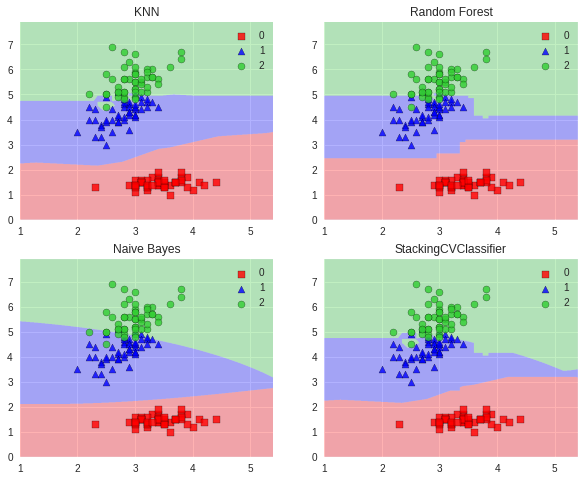

In [5]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

for clf, lab, grd in zip([clf1, clf2, clf3, sclf], 
                         ['KNN', 
                          'Random Forest', 
                          'Naive Bayes',
                          'StackingCVClassifier'],
                          itertools.product([0, 1], repeat=2)):

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)
plt.show()

## Using Probabilities as Meta-Features
Alternatively, the class-probabilities of the first-level classifiers can be used to train the meta-classifier (2nd-level classifier) by setting use_probas=True. For example, in a 3-class setting with 2 level-1 classifiers, these classifiers may make the following "probability" predictions for 1 training sample:

classifier 1: [0.2, 0.5, 0.3]
classifier 2: [0.3, 0.4, 0.4]
This results in k features, where k = [n_classes * n_classifiers], by stacking these level-1 probabilities:

[0.2, 0.5, 0.3, 0.3, 0.4, 0.4]

In [6]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()

# The StackingCVClassifier uses scikit-learn's check_cv
# internally, which doesn't support a random seed. Thus
# NumPy's random seed need to be specified explicitely for
# deterministic behavior
np.random.seed(RANDOM_SEED)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            use_probas=True,
                            meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.91 (+/- 0.06) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.95 (+/- 0.04) [StackingClassifier]


## Stacked CV Classification and GridSearch
To set up a parameter grid for scikit-learn's GridSearch, we simply provide the estimator's names in the parameter grid -- in the special case of the meta-regressor, we append the 'meta-' prefix.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

# The StackingCVClassifier uses scikit-learn's check_cv
# internally, which doesn't support a random seed. Thus
# NumPy's random seed need to be specified explicitely for
# deterministic behavior
np.random.seed(RANDOM_SEED)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], 
                            meta_classifier=lr)

params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta-logisticregression__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.673 +/- 0.01 {'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier__n_neighbors': 1}
0.667 +/- 0.00 {'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 50, 'kneighborsclassifier__n_neighbors': 1}
0.920 +/- 0.02 {'meta-logisticregression__C': 10.0, 'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier__n_neighbors': 1}
0.893 +/- 0.02 {'meta-logisticregression__C': 10.0, 'randomforestclassifier__n_estimators': 50, 'kneighborsclassifier__n_neighbors': 1}
0.667 +/- 0.00 {'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier__n_neighbors': 5}
0.667 +/- 0.00 {'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 50, 'kneighborsclassifier__n_neighbors': 5}
0.947 +/- 0.02 {'meta-logisticregression__C': 10.0, 'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier__n_neighbors': 5}
0.947 +/- 0.02 {'meta-logisticregression__C': 10.0, 

In case we are planning to use a regression algorithm multiple times, all we need to do is to add an additional number suffix in the parameter grid as shown below:

In [8]:
from sklearn.model_selection import GridSearchCV

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

# The StackingCVClassifier uses scikit-learn's check_cv
# internally, which doesn't support a random seed. Thus
# NumPy's random seed need to be specified explicitely for
# deterministic behavior
np.random.seed(RANDOM_SEED)
sclf = StackingCVClassifier(classifiers=[clf1, clf1, clf2, clf3], 
                            meta_classifier=lr)

params = {'kneighborsclassifier-1__n_neighbors': [1, 5],
          'kneighborsclassifier-2__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta-logisticregression__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.673 +/- 0.01 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'randomforestclassifier__n_estimators': 10, 'meta-logisticregression__C': 0.1}
0.667 +/- 0.00 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'randomforestclassifier__n_estimators': 50, 'meta-logisticregression__C': 0.1}
0.920 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'randomforestclassifier__n_estimators': 10, 'meta-logisticregression__C': 10.0}
0.893 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'randomforestclassifier__n_estimators': 50, 'meta-logisticregression__C': 10.0}
0.667 +/- 0.00 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'randomforestclassifier__n_estimators': 10, 'meta-logisticregression__C': 0.1}
0.667 +/- 0.00 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'ra

### Note

The StackingCVClassifier also enables grid search over the classifiers argument. However, due to the current implementation of GridSearchCV in scikit-learn, it is not possible to search over both, differenct classifiers and classifier parameters at the same time. For instance, while the following parameter dictionary works

params = {'randomforestclassifier__n_estimators': [1, 100],
'classifiers': [(clf1, clf1, clf1), (clf2, clf3)]}
it will use the instance settings of clf1, clf2, and clf3 and not overwrite it with the 'n_estimators' settings from 'randomforestclassifier__n_estimators': [1, 100].



## Stacking of Classifiers that Operate on Different Feature Subsets
The different level-1 classifiers can be fit to different subsets of features in the training dataset. The following example illustrates how this can be done on a technical level using scikit-learn pipelines and the ColumnSelector:

In [9]:
from sklearn.datasets import load_iris
from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

iris = load_iris()
X = iris.data
y = iris.target

pipe1 = make_pipeline(ColumnSelector(cols=(0, 2)),
                      LogisticRegression())
pipe2 = make_pipeline(ColumnSelector(cols=(1, 2, 3)),
                      LogisticRegression())

sclf = StackingCVClassifier(classifiers=[pipe1, pipe2], 
                            meta_classifier=LogisticRegression())

sclf.fit(X, y)

StackingCVClassifier(classifiers=[Pipeline(memory=None,
     steps=[('columnselector', ColumnSelector(cols=(0, 2), drop_axis=False)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          pen...='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])],
           cv=2,
           meta_classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
           refit=True, shuffle=True, store_train_meta_features=False,
           stratify=True, use_features_in_secondary=False,
           use_probas=False, verbose=0)